## 1. Importar bibliotecas

In [15]:
# Importar bibliotecas
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2. Coletar dados

In [2]:
# Ticker da empresa
ticker = 'VALE3.SA'
start_date = '2024-01-01'
end_date = date.today()

In [3]:
# Baixar dados históricos de preço
df = yf.download(ticker, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,77.599998,78.180000,76.589996,77.050003,71.151764,18021800
2024-01-03,76.709999,76.900002,75.849998,76.650002,70.782379,25315100
2024-01-04,76.430000,76.639999,75.360001,75.620003,69.831230,18707000
2024-01-05,75.029999,75.050003,74.120003,74.650002,68.935486,21082500
2024-01-08,73.940002,74.559998,73.510002,74.269997,68.584572,23013300


## 3. Processar dados

In [4]:
# Tratar valores ausentes
df = df.dropna()

In [5]:
# Setar variáveis
feature = df['Close']

In [6]:
# Criação de features para médias móveis
df['SMA_10'] = feature.rolling(window = 10).mean()
df['SMA_50'] = feature.rolling(window = 50).mean()
df['SMA_200'] = feature.rolling(window = 200).mean()

In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_50,SMA_200
Date,,,,,,,,,
2024-01-02,77.599998,78.180000,76.589996,77.050003,71.151764,18021800,NaN,NaN,NaN
2024-01-03,76.709999,76.900002,75.849998,76.650002,70.782379,25315100,NaN,NaN,NaN
2024-01-04,76.430000,76.639999,75.360001,75.620003,69.831230,18707000,NaN,NaN,NaN
2024-01-05,75.029999,75.050003,74.120003,74.650002,68.935486,21082500,NaN,NaN,NaN
2024-01-08,73.940002,74.559998,73.510002,74.269997,68.584572,23013300,NaN,NaN,NaN


In [8]:
# Normalizar os dados
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Close']])
df_scaled

array([[1.        ],
       [0.98099755],
       [0.9320665 ],
       [0.88598569],
       [0.86793321],
       [0.82327788],
       [0.77102143],
       [0.78907355],
       [0.74536818],
       [0.73871738],
       [0.69453685],
       [0.63420411],
       [0.61757711],
       [0.5748217 ],
       [0.56057013],
       [0.62707815],
       [0.66033252],
       [0.57862226],
       [0.64133007],
       [0.62565303],
       [0.60712574],
       [0.55866985],
       [0.54394277],
       [0.47885988],
       [0.45178151],
       [0.5068882 ],
       [0.5130642 ],
       [0.48503552],
       [0.47125875],
       [0.46175771],
       [0.45178151],
       [0.57007118],
       [0.54584305],
       [0.47553447],
       [0.49928744],
       [0.53301661],
       [0.54061737],
       [0.46318283],
       [0.54536825],
       [0.5102136 ],
       [0.52209008],
       [0.5168644 ],
       [0.5097388 ],
       [0.46793335],
       [0.51068876],
       [0.49976224],
       [0.47553447],
       [0.378

## 4. Primeiros passos com LSTM

In [9]:
# Séries temporais
def create_serie(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(np.array(x))
        ys.append(np.array(y))
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50 # tamanha da série
x, y = create_serie(df_scaled, SEQ_LENGTH)

# Dividindo dados entre treino e teste
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:] 

### 4.1 Construir modelo

In [11]:
# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))  # Saída única para o preço de fechamento

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Treinando o modelo
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))


c:\Users\55119\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - loss: 0.0474 - val_loss: 0.0118
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0088 - val_loss: 0.0122
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0083 - val_loss: 0.0129
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0094 - val_loss: 0.0105
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0067 - val_loss: 0.0094
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0069 - val_loss: 0.0093
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0067 - val_loss: 0.0096
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0066 - val_loss: 0.0096
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0063 - val_loss: 0.0092
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0064 - val_loss: 0.0088
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0059 - val_loss: 0.0087


## 5. Avaliar modelo

In [14]:
# Fazendo previsões
y_predict = model.predict(x_test)

mae = mean_absolute_error(y_test, y_predict)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))

print(f'MAE: {mae}, RMSE: {rmse}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
MAE: 0.06781867110105119, RMSE: 0.08957140720718083


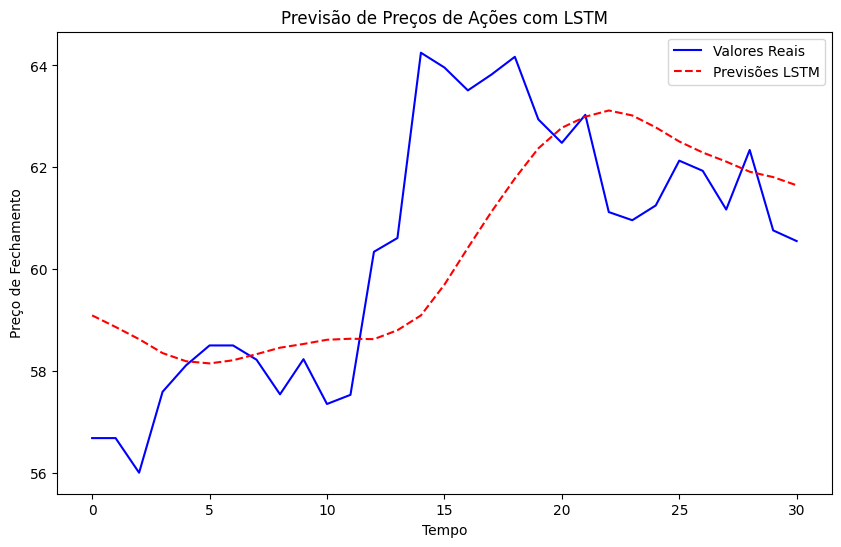

In [16]:
y_predict = scaler.inverse_transform(y_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotar os valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reais', color='blue')
plt.plot(y_predict, label='Previsões LSTM', color='red', linestyle='dashed')
plt.title('Previsão de Preços de Ações com LSTM')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()
